

# Import libraries.


In [ ]:
# Core
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
import os
import cv2
#tesor fow & keras
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2     
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization,Dropout,Input
from keras.models import Sequential, Model
from keras.layers import Conv2D,GlobalMaxPooling2D
from tensorflow.keras.applications import  Xception,VGG16,InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#cnn
from tensorflow.keras import datasets, layers, models

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.engine.base_layer import Layer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [ ]:
seed = 42
np.random.seed =seed

In [ ]:
image_path = './'

# Helper Function




In [11]:
#this function used to get code simple

# get label Name   
def get_Label(number):
    labels = {0:'saree', 1:'jeans', 2:'trouser'}
    return labels[number]


#plot predction function
def plot_predection(model_name):
    plt.figure(figsize=(20,15))
    plt.suptitle("Predection  Images", fontsize=20)
    images = [] 
    path =image_path+'/'+'test/'
    count = 0  #val_images,val_labels
    for i,files in enumerate(os.listdir(path)) :
        img = plt.imread(path+files)
        img = cv2.resize(img,(128,128))
        plt.imshow(img,cmap=plt.cm.binary)
        img = np.expand_dims(img, axis=0)
        feature = model_name.predict(img)
        predection  = np.argmax(feature, axis=1)
        plt.subplot(5,7,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel("Predicted"+get_Label(int(predection)))
        count += 1
        if count == 34 :
            break                


# Data Preperation 
Load Labels
*   collect all image label and add it in data frame.

Load Images
*   Train images
*   Test images
*   Validation images



In [12]:
# 0 for saree ,1 for jeans ,2 for trouser
all_categories = []
images = os.listdir(image_path+'/'+'train')
for file in images:
    if file.split('.')[0] == 'saree':
        all_categories.append(0)
    elif file.split('.')[0] == 'jeans':
        all_categories.append(1)
    else:
        all_categories.append(2)
#creat data fram to save each image with its label 
df =pd.DataFrame({
    'image': images,
    'category':all_categories
})

df.head(5)

,image,category
0,saree.0.jpg,0
1,saree.2.jpg,0
2,saree.1.jpg,0
3,saree.10.jpg,0
4,saree.3.jpg,0


In [13]:
df['category'].value_counts()

0    200
1    200
2    200
Name: category, dtype: int64

# Virsialization Train Images 

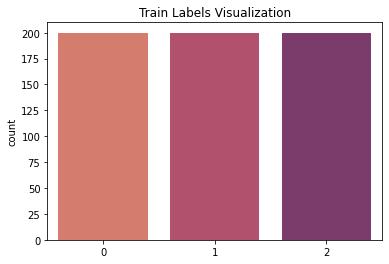

In [14]:
plt.title('Train Labels Visualization')
sns.countplot(x=all_categories,palette='flare')
plt.show()



*   Frome Here We Find Data is Totaly Balanced.



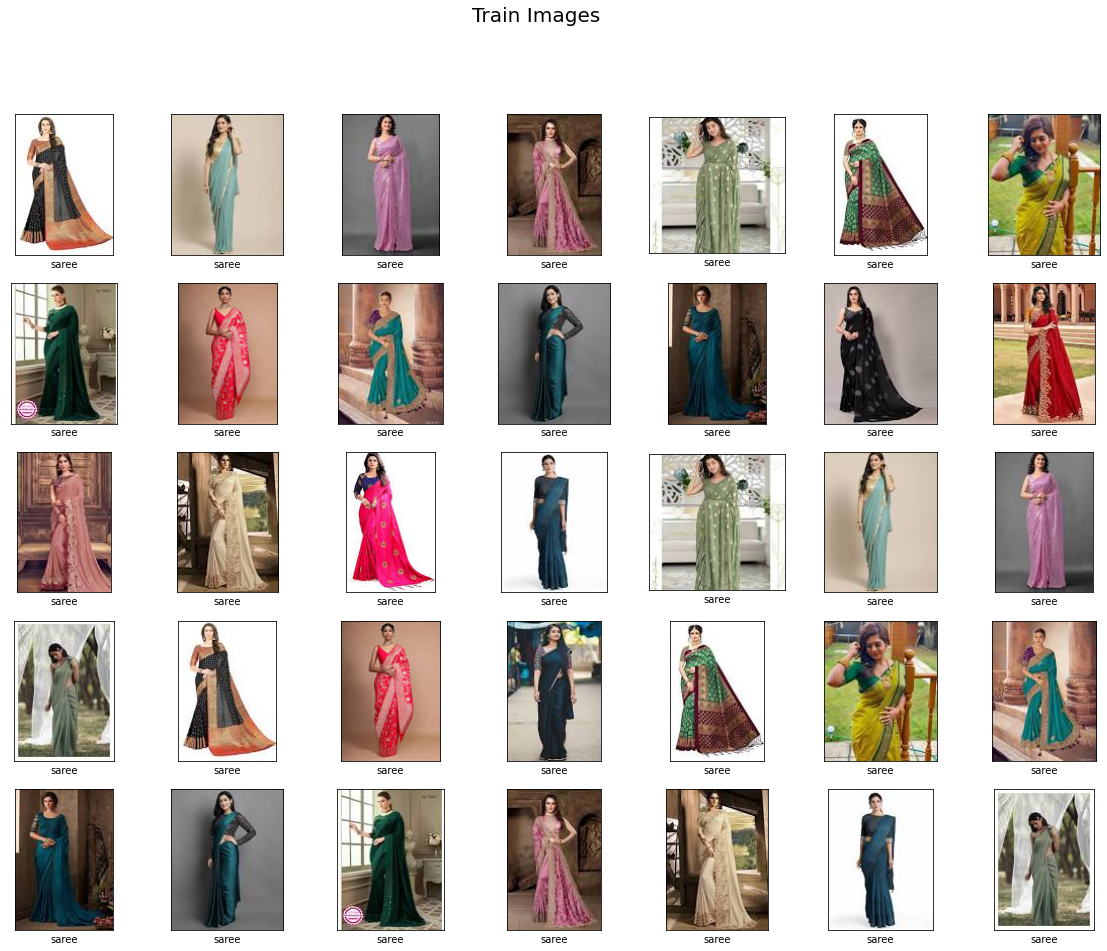

In [15]:
plt.figure(figsize=(20,15))
plt.suptitle("Train Images", fontsize=20)
path =image_path+'/'+'train/'
counter =0
for i,img in enumerate(os.listdir(path))  :
        plt.subplot(5,7,i+1)
        full_image= plt.imread(path+img)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.xlabel(get_Label(all_categories[i]))
        plt.imshow(full_image, cmap=plt.cm.binary) 
        if i == 34:
            break

In [16]:
#conver label to categorical in stead of numerical value to use feature of image generator 
df['category'] = df['category'].replace({1:'jeans',0:'saree',2:'trouser'})
df.head(10)

,image,category
0,saree.0.jpg,saree
1,saree.2.jpg,saree
2,saree.1.jpg,saree
3,saree.10.jpg,saree
4,saree.3.jpg,saree
5,saree.6.jpg,saree
6,saree.8.jpg,saree
7,saree.9.jpg,saree
8,saree.4.jpg,saree
9,saree.7.jpg,saree


In [17]:
df['category'].value_counts()

saree      200
jeans      200
trouser    200
Name: category, dtype: int64

# Data Preperation


1.   Data speliting
2.   re index to spleated data to order data 
3.   get shape of data



In [18]:
#splid data to train and test
x_train,x_val  = train_test_split(df ,random_state=42,shuffle=True,test_size=0.1)

In [19]:
x_train['category'].value_counts()

jeans      187
trouser    180
saree      173
Name: category, dtype: int64

In [20]:
x_val['category'].value_counts()

saree      27
trouser    20
jeans      13
Name: category, dtype: int64

In [21]:
# reindex Data Frame
x_train = x_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)


In [22]:
print('Train Images shape is        : ',x_train.shape)
print('Validation  Images  shape is : ',x_val.shape)

Train Images shape is        :  (540, 2)
Validation  Images  shape is :  (60, 2)


# Buliding CNN Model

**i will use Data augmentation,as it  is a set of techniques to artificially increase the amount of data by generating new data points from existing data. This includes making small changes to data or using deep learning models to generate new data points.** 



In [23]:
batch_size = 64
#create image generator for images 
image_gen = ImageDataGenerator(
                                 rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.5,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  fill_mode='nearest',
                                   horizontal_flip=True,
                                   rotation_range = 20, 
                            
                               )

# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(  
                                   rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.5,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  fill_mode='nearest',
                                   horizontal_flip=True,
                                   rotation_range = 20,)

        
train = image_gen.flow_from_dataframe(
      x_train,
      image_path+'/'+'train/',
      x_col='image',
      y_col='category',
      target_size=(128,128),
      class_mode='categorical',
      shuffle=True, 
      batch_size=batch_size
      )
validate = test_data_gen.flow_from_dataframe(
      x_val,
      image_path+'/'+'train/',
      x_col='image',
      y_col='category',
      target_size=(128,128),
      class_mode='categorical',
      shuffle=True, 
      batch_size=batch_size
      )


Found 540 validated image filenames belonging to 3 classes.
Found 60 validated image filenames belonging to 3 classes.


In [24]:
# get shape of train data 
for train_img , train_label in train :
    print('image shape ',train_img.shape)
    print('label  shape ',train_label.shape)
    break 

image shape  (64, 128, 128, 3)
label  shape  (64, 3)


In [25]:
# get shape of train data 
for v_img , v_label in validate :
    print('image shape ',v_img.shape)
    print('label  shape ',v_label.shape)
    break 

image shape  (60, 128, 128, 3)
label  shape  (60, 3)


In [37]:
#start bulding CNN Model
cnn_model = Sequential()
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(64,(3,3),padding ='Same',activation = 'relu',input_shape=(128,128,3)))
cnn_model.add(layers.MaxPooling2D(2,2))
cnn_model.add(layers.Conv2D(64,(3,3) ,padding ='same',activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2))
cnn_model.add(layers.Conv2D(128,(3,3),padding ='same',activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2)) 
cnn_model.add(layers.Conv2D(128,(3,3) ,padding ='same',activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2)) 
cnn_model.add(layers.Conv2D(256,(3,3) ,padding ='same',activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2)) 
cnn_model.add(BatchNormalization())
cnn_model.add(layers.Conv2D(256,(3,3) ,padding ='same',activation='relu'))
cnn_model.add(layers.MaxPooling2D(2,2)) 
cnn_model.add(BatchNormalization())
cnn_model.summary()
# cnn_model.add(Dropout(0.2))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 128)     

In [38]:
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(1024, activation='relu'))
cnn_model.add(BatchNormalization())
# cnn_model.add(Dropout(0.7))
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(BatchNormalization())
# cnn_model.add(Dropout(0.3))
cnn_model.add(layers.Dense(3, activation ='softmax'))
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 128)     

In [39]:
cnn_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)

  **1-Defining Callbacks**

*   A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)


**2-Reduce Learning Rate on Plateau**
*   Is used to reduce the learning rate when a metric has stopped improving.



In [40]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [41]:
# Training model
n_training_samples = len(train)
n_validation_samples = len(validate)
history = cnn_model.fit(
    train,
    epochs=60,
    validation_data=validate,
    validation_steps=n_validation_samples//batch_size,
    # steps_per_epoch =n_training_samples//batch_size,
    shuffle = True,
    callbacks=callbacks_list
    )

Epoch 1/60
9/9 [==============================] - 34s 4s/step - loss: 1.2073 - accuracy: 0.6444 - lr: 0.0010
Epoch 2/60
9/9 [==============================] - 29s 3s/step - loss: 0.5689 - accuracy: 0.7741 - lr: 0.0010
Epoch 3/60
9/9 [==============================] - 29s 3s/step - loss: 0.4743 - accuracy: 0.8204 - lr: 0.0010
Epoch 4/60
9/9 [==============================] - 29s 3s/step - loss: 0.3617 - accuracy: 0.8593 - lr: 0.0010
Epoch 5/60
9/9 [==============================] - 29s 3s/step - loss: 0.4050 - accuracy: 0.8463 - lr: 0.0010
Epoch 6/60
9/9 [==============================] - 30s 3s/step - loss: 0.3134 - accuracy: 0.8944 - lr: 0.0010
Epoch 7/60
9/9 [==============================] - 29s 3s/step - loss: 0.2262 - accuracy: 0.9000 - lr: 0.0010
Epoch 8/60
9/9 [==============================] - 29s 3s/step - loss: 0.1601 - accuracy: 0.9370 - lr: 0.0010
Epoch 9/60
9/9 [==============================] - 29s 3s/step - loss: 0.2468 - accuracy: 0.9111 - lr: 0.0010
Epoch 10/60
9/9 [==

In [42]:
score, acc = cnn_model.evaluate(validate,batch_size=batch_size)                       
print('Test score:', score)
print('Test accuracy:', acc)

1/1 [==============================] - 1s 1s/step - loss: 0.7665 - accuracy: 0.5833
Test score: 0.766460657119751
Test accuracy: 0.5833333134651184


In [43]:
cnn_prediction = cnn_model.predict(validate)
cnn_prediction

array([[6.0740672e-03, 4.3969736e-01, 5.5422860e-01],
       [4.7305265e-01, 3.0753916e-04, 5.2663976e-01],
       [9.9928409e-01, 3.8402650e-05, 6.7763252e-04],
       [7.4064070e-01, 1.6429554e-01, 9.5063761e-02],
       [9.9933052e-01, 1.6761982e-05, 6.5274647e-04],
       [5.5768162e-01, 2.5943507e-04, 4.4205898e-01],
       [1.1244741e-03, 8.4340709e-01, 1.5546840e-01],
       [2.2699898e-02, 5.5012858e-01, 4.2717159e-01],
       [3.2665182e-03, 9.4743294e-01, 4.9300544e-02],
       [9.6781865e-02, 3.0162296e-04, 9.0291649e-01],
       [2.9386247e-03, 1.8956615e-01, 8.0749518e-01],
       [3.8221413e-01, 6.1053562e-01, 7.2502135e-03],
       [3.6263054e-03, 4.8065420e-02, 9.4830829e-01],
       [6.7344820e-01, 2.9335389e-04, 3.2625845e-01],
       [1.3854073e-01, 4.9493503e-04, 8.6096436e-01],
       [1.8495403e-02, 7.5790805e-01, 2.2359657e-01],
       [2.9311559e-01, 1.2287203e-03, 7.0565563e-01],
       [9.9999177e-01, 6.0371722e-06, 2.1204394e-06],
       [3.0496912e-03, 4.585

KeyError: ignored

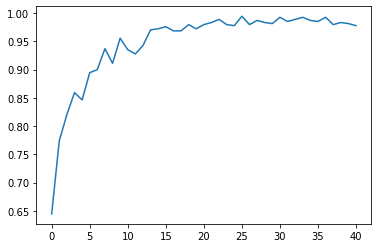

In [44]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

# prepare data for predection.






In [49]:
#get image path
test_images = os.listdir(image_path+'/'+'test')

#creat data frame
df_test =pd.DataFrame({
    'image': test_images,
})

df_test.head()

#prepare generator
val_data_gen  = ImageDataGenerator( rescale = 1./255, )  
        
testing = val_data_gen.flow_from_dataframe(
      df_test,
      image_path+'/'+'test/',
      x_col='image',
      y_col= None,
      target_size=(128,128),
      class_mode=None,
      shuffle=True, 
      batch_size=batch_size
      )


Found 300 validated image filenames.


# Predction Using CNN.

In [50]:
predection = cnn_model.predict(testing)
predection

array([[9.9828088e-01, 2.0129165e-04, 1.5178961e-03],
       [2.4121670e-01, 7.1161896e-01, 4.7164325e-02],
       [9.9995387e-01, 1.5913571e-05, 3.0276049e-05],
       [4.2148307e-01, 2.3551409e-04, 5.7828134e-01],
       [1.9690374e-01, 4.6537718e-01, 3.3771905e-01],
       [3.6556481e-03, 3.8270804e-03, 9.9251723e-01],
       [5.0667960e-02, 9.9274970e-05, 9.4923276e-01],
       [9.3969893e-01, 4.0891377e-05, 6.0260154e-02],
       [8.0193632e-04, 9.9667102e-01, 2.5270446e-03],
       [6.8162203e-01, 2.9663473e-01, 2.1743212e-02],
       [9.9515659e-01, 6.4511078e-06, 4.8370031e-03],
       [2.9665694e-01, 4.0969037e-04, 7.0293331e-01],
       [2.3660478e-03, 2.2710459e-01, 7.7052933e-01],
       [2.3359541e-02, 2.7761620e-04, 9.7636288e-01],
       [6.8452051e-03, 4.9811995e-01, 4.9503487e-01],
       [1.3979766e-01, 1.2548368e-03, 8.5894746e-01],
       [3.4633341e-01, 5.9526461e-01, 5.8401983e-02],
       [9.8789740e-01, 5.9893867e-03, 6.1133089e-03],
       [9.9912924e-01, 2.558

In [51]:
np.argmax(predection,axis=1)[0:100]

array([0, 1, 0, 2, 1, 2, 2, 0, 1, 0, 0, 2, 2, 2, 1, 2, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 2, 1, 0, 0, 0, 1, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2,
       2, 0, 2, 0, 1, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 1,
       2, 2, 0, 0, 1, 0, 2, 2, 1, 2, 2, 2, 0, 2, 0, 0, 1, 0, 0, 1, 2, 1,
       1, 1, 2, 2, 2, 2, 0, 0, 2, 1, 2, 0])

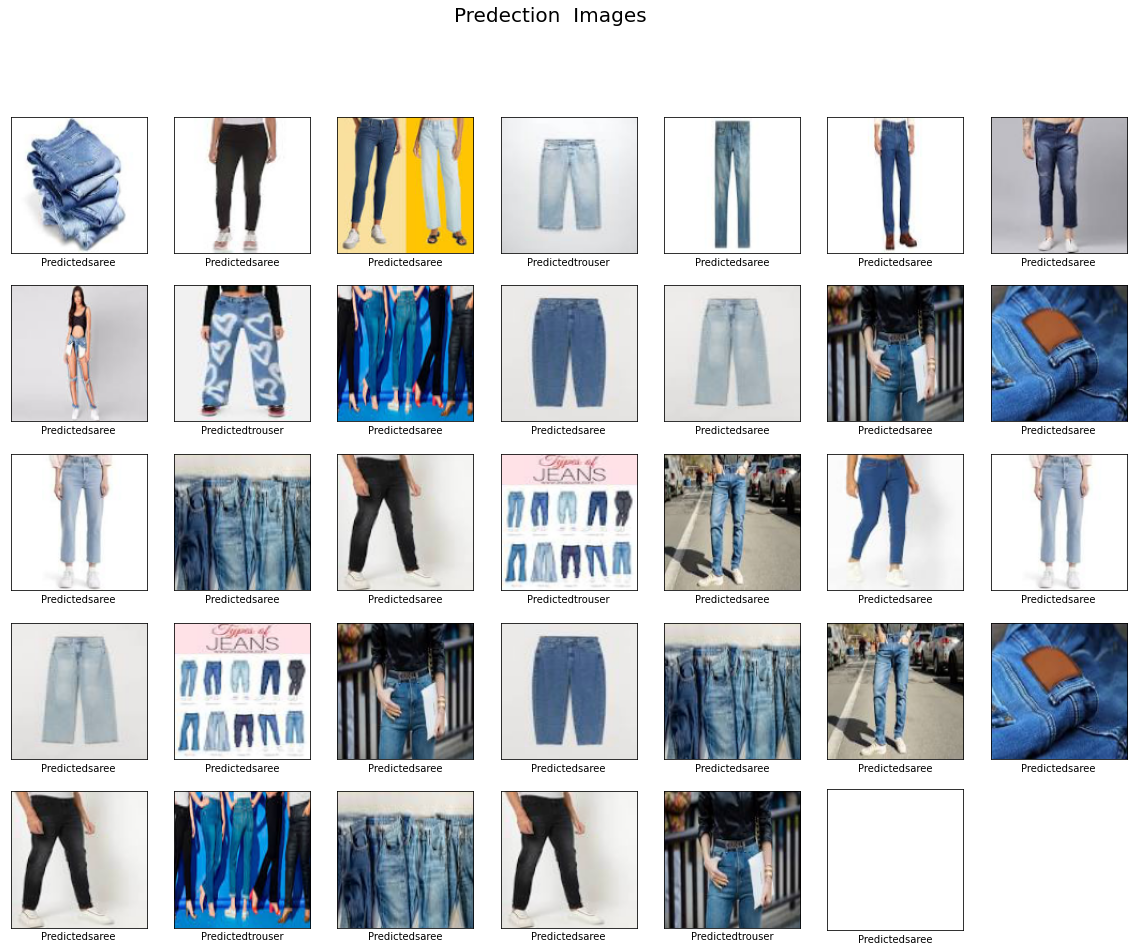

In [52]:
plot_predection(cnn_model)